**A fun project to train a model over tweets of Donald Trump and try to create new tweets.
As a start, I will use simple LSTM model and try to choose better hyperparameters and improve performance over the time. As a conclusion for this small project will try to use Transformers to generate new tweet.**

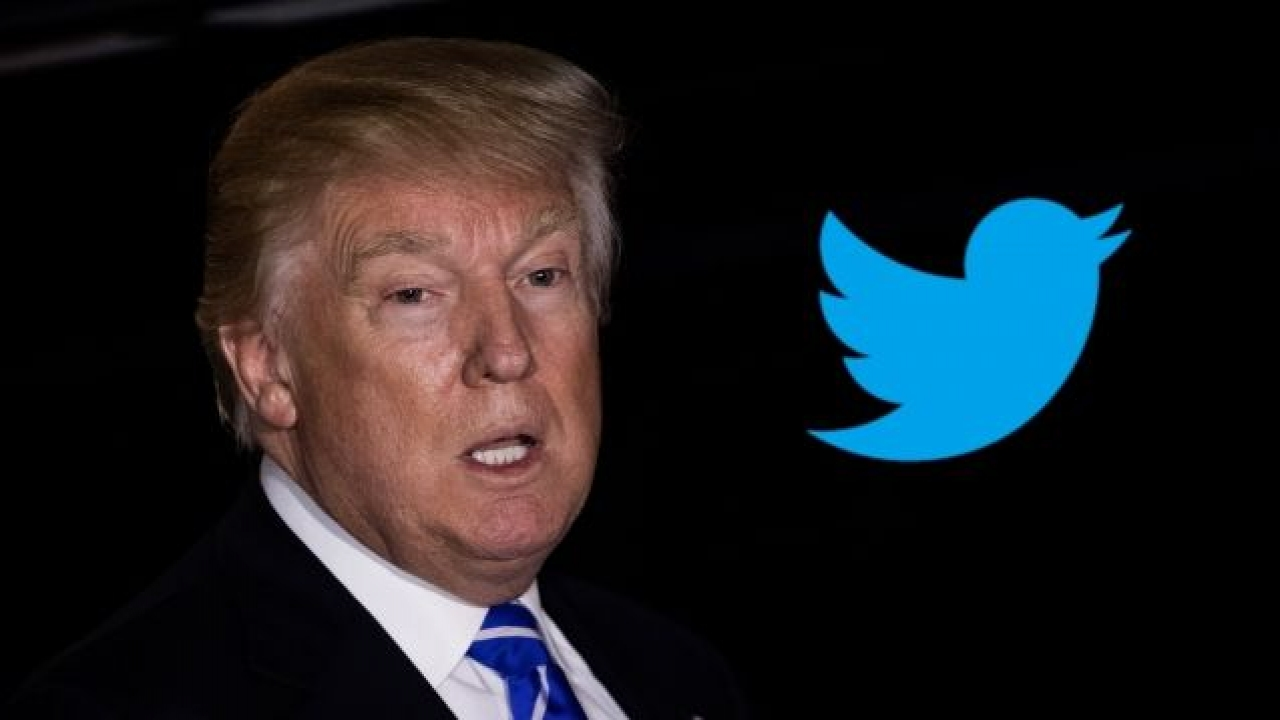

In [1]:
import sys
import numpy as np
import pandas as pd
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import nltk

In [2]:
data = pd.read_csv('../input/all-trumps-twitter-insults-20152021/trump_insult_tweets_2014_to_2021.csv')
#data.head()
data.shape

(10360, 5)

**I will be using only the tweet column from the dataset. Then will convert all the text to lowercase, as it improves performance and also it is fast to train with less values to predict.**

In [3]:
text = ''
for i in range(10360):
    text += data.tweet[i]
    text += '\n'

In [4]:
text = text.lower()

In [5]:
words = set(nltk.corpus.words.words())
text = " ".join(w for w in nltk.wordpunct_tokenize(text) \
         if w.lower() in words or not w.isalpha())

In [6]:
del data
gc.collect()

69

**Applying regex operation to remove some irrelevant and less frequent character occurances. Then we create a vocabulary to store unique character that we will be feeding to our model.**

In [7]:
import re
text = re.sub(r'\W+', ' ', text)

In [8]:
vocab = sorted(list(set(text)))
len(vocab)

40

**Next we create a dictionary to map these characters to numbers that can be fed to model.**

In [9]:
char2id = dict((c, i) for i, c in enumerate(vocab))

input_len = len(text)
vocab_len = len(vocab)
print ("Total number of characters:", input_len)
print ("Total vocab:", vocab_len)

Total number of characters: 1611030
Total vocab: 40


In [10]:
seq_length = 100
X_data = []
y_data = []

In [11]:
for i in range(0, input_len - seq_length, 1):
    in_seq = text[i:i + seq_length]
    out_seq = text[i + seq_length]
    X_data.append([char2id[char] for char in in_seq])
    y_data.append(char2id[out_seq])

In [12]:
n_patterns = len(X_data)
print ("Total Patterns:", n_patterns)

Total Patterns: 1610930


In [13]:
X = np.reshape(X_data, (n_patterns, seq_length, 1))
X = X/float(vocab_len)

In [14]:
from keras.utils import np_utils

y = np_utils.to_categorical(y_data)

In [15]:
gc.collect()

20

In [16]:
training = True

def create_model():
    model = Sequential()
    #model.add(Embedding(vocab_len,64))
    model.add(LSTM (256,return_sequences=True))
    model.add(Dropout(0.25))
    model.add(LSTM (256))
    #model.add(Dropout(0.25))
    #model.add(Dense(64,activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [17]:
import pickle


if training:
    model = create_model()
    model.fit(X, y, epochs=50, batch_size=1024)
    model.save('trump_tweet.h5')
    '''Pkl_Filename = "Tweeter.pkl"  

    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(model, file)'''
else:
    from tensorflow import keras
    model = keras.models.load_model('../input/trump-tweet-generation/trump_tweet/saved_model.pb')

Epoch 1/50
1574/1574 [==============================] - 186s 114ms/step - loss: 2.7065
Epoch 2/50
1574/1574 [==============================] - 179s 114ms/step - loss: 2.0305
Epoch 3/50
1574/1574 [==============================] - 179s 114ms/step - loss: 1.7569
Epoch 4/50
1574/1574 [==============================] - 179s 114ms/step - loss: 1.6231
Epoch 5/50
1574/1574 [==============================] - 180s 114ms/step - loss: 1.5405
Epoch 6/50
1574/1574 [==============================] - 180s 114ms/step - loss: 1.4763
Epoch 7/50
1574/1574 [==============================] - 180s 114ms/step - loss: 1.4318
Epoch 8/50
1574/1574 [==============================] - 179s 114ms/step - loss: 1.3926
Epoch 9/50
1574/1574 [==============================] - 179s 114ms/step - loss: 1.3629
Epoch 10/50
1574/1574 [==============================] - 179s 114ms/step - loss: 1.3370
Epoch 11/50
1574/1574 [==============================] - 179s 114ms/step - loss: 1.3134
Epoch 12/50
1574/1574 [==================

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 256)          264192    
_________________________________________________________________
dropout (Dropout)            (None, 100, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 40)                10280     
Total params: 799,784
Trainable params: 799,784
Non-trainable params: 0
_________________________________________________________________


**After training the model let's try to check it's performance by doing some text generation. Before generating some text we need to convert generated numbers back to readable character form.**

In [19]:
id2char = dict((i, c) for i, c in enumerate(vocab))

**Firstly let's start with random text from our data that we trained upon.**

In [20]:
start = np.random.randint(0, len(X_data) - 1)
pattern = X_data[start]
print("Random Data Seed:")
print("\"", ''.join([id2char[value] for value in pattern]), "\"")

Random Data Seed:
" zy and so bad for our country can you imagine what will happen during that nine day period the elect "


In [21]:
for i in range(250):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(vocab_len)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = id2char[index]
    seq_in = [id2char[value] for value in pattern]

    sys.stdout.write(result)

    pattern.append(index)
    pattern = pattern[1:len(pattern)]

ion in the history of our country the fake news media is doing everything possible to start she is a total fraud on the fake news media the fake news media is doing everything possible to start she is a total fraud on the fake news media the fake new

**Let's use a tweet from Trump's account from 2012.**

In [22]:
tweet_2012 = 'it makes me feel so good to hit sleazebags back much better than seeing a psychiatrist which i never have'

In [23]:
new_pattern = [char2id[value] for value in tweet_2012]

In [24]:
for i in range(250):
    x = np.reshape(new_pattern, (1, len(new_pattern), 1))
    x = x / float(vocab_len)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = id2char[index]
    seq_in = [id2char[value] for value in pattern]

    sys.stdout.write(result)

    new_pattern.append(index)
    new_pattern = new_pattern[1:len(pattern)]

  said and the people of the witch hunt is the enemy of the people the fake news media is doing everything possible to start she is a total fraud on the fake news media the fake news media is doing everything possible to start she is a total fraud on